In [1]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")

In [3]:
db = client["Global_Coffee_Consumption"]

In [4]:
collection_names = db.list_collection_names()

In [5]:
print(collection_names)

['Coffee_ImportersConsumption', 'Coffee_DomesticConsumption', 'Coffee_imports', 'Coffee_production', 'Coffee_exports']


In [11]:
collection1 = db.Coffee_DomesticConsumption
collection2 = db.Coffee_ImportersConsumption
collection3 = db.Coffee_exports
collection4 = db.Coffee_imports
collection5 = db.Coffee_production

collection1.find_one()
list(collection1.find({}, {"_id": 0}))

[{'Country': 'Angola',
  'Coffee type': 'Robusta/Arabica',
  '1990/91': 1200000,
  '1991/92': 1800000,
  '1992/93': 2100000,
  '1993/94': 1200000,
  '1994/95': 1500000,
  '1995/96': 600000,
  '1996/97': 1200000,
  '1997/98': 2400000,
  '1998/99': 1800000,
  '1999/00': 1200000,
  '2000/01': 1200000,
  '2001/02': 1200000,
  '2002/03': 1200000,
  '2003/04': 900000,
  '2004/05': 900000,
  '2005/06': 900000,
  '2006/07': 1800000,
  '2007/08': 1800000,
  '2008/09': 1800000,
  '2009/10': 1800000,
  '2010/11': 1800000,
  '2011/12': 1800000,
  '2012/13': 1800000,
  '2013/14': 1800000,
  '2014/15': 1800000,
  '2015/16': 1800000,
  '2016/17': 1800000,
  '2017/18': 1800000,
  '2018/19': 1800000,
  '2019/20': 1800000,
  'Total_domestic_consumption': 46500000},
 {'Country': 'Bolivia (Plurinational State of)',
  'Coffee type': 'Arabica',
  '1990/91': 1500000,
  '1991/92': 1620000,
  '1992/93': 1650000,
  '1993/94': 1710000,
  '1994/95': 1770000,
  '1995/96': 1830000,
  '1996/97': 1890000,
  '1997/98'

In [14]:
pd.DataFrame(collection1.find({}, {"_id": 0, "id":0})).to_dict(orient="list")

{'Country': ['Angola',
  'Bolivia (Plurinational State of)',
  'Brazil',
  'Burundi',
  'Ecuador',
  'Indonesia',
  'Madagascar',
  'Malawi',
  'Papua New Guinea',
  'Paraguay',
  'Peru',
  'Rwanda',
  'Timor-Leste',
  'Zimbabwe',
  'Congo',
  'Cuba',
  'Dominican Republic',
  'Haiti',
  'Philippines',
  'Tanzania',
  'Zambia',
  'Cameroon',
  'Central African Republic',
  'Colombia',
  'Costa Rica',
  "Côte d'Ivoire",
  'Democratic Republic of Congo',
  'El Salvador',
  'Equatorial Guinea',
  'Ethiopia',
  'Gabon',
  'Ghana',
  'Guatemala',
  'Guinea',
  'Guyana',
  'Honduras',
  'India',
  'Jamaica',
  'Kenya',
  "Lao People's Democratic Republic",
  'Liberia',
  'Mexico',
  'Nepal',
  'Nicaragua',
  'Nigeria',
  'Panama',
  'Sierra Leone',
  'Sri Lanka',
  'Thailand',
  'Togo',
  'Trinidad & Tobago',
  'Uganda',
  'Venezuela',
  'Viet Nam',
  'Yemen'],
 'Coffee type': ['Robusta/Arabica',
  'Arabica',
  'Arabica/Robusta',
  'Arabica/Robusta',
  'Arabica/Robusta',
  'Robusta/Arabica',

In [15]:
pd.DataFrame(collection2.find({}, {"_id": 0, "id":0})).to_dict(orient="list")

{'1990': [80400000,
  0,
  67440000,
  6120000,
  0,
  1860000,
  39540000,
  51900000,
  0,
  64200000,
  312300000,
  436740000,
  37860000,
  34440000,
  7200000,
  289920000,
  0,
  0,
  0,
  1200000,
  142980000,
  20100000,
  28020000,
  26520000,
  0,
  0,
  162840000,
  101340000,
  303600000,
  43620000,
  0,
  54420000,
  6060000,
  140880000,
  1097880000],
 '1991': [78120000,
  0,
  42480000,
  1020000,
  0,
  2700000,
  31500000,
  54540000,
  0,
  57960000,
  333420000,
  742620000,
  23220000,
  22800000,
  6780000,
  255240000,
  0,
  0,
  0,
  780000,
  149280000,
  14580000,
  26880000,
  20100000,
  0,
  0,
  159060000,
  96240000,
  348540000,
  45480000,
  0,
  56940000,
  5400000,
  140520000,
  1119660000],
 '1992': [72720000,
  0,
  41760000,
  10500000,
  8100000,
  2340000,
  28320000,
  57540000,
  780000,
  61800000,
  336840000,
  574200000,
  19200000,
  20880000,
  5460000,
  247920000,
  1140000,
  120000,
  0,
  960000,
  195660000,
  99000000,
  343800

In [16]:
pd.DataFrame(collection3.find({}, {"_id": 0, "id":0})).to_dict(orient="list")

{'1990': [5040000,
  9360000,
  1016160000,
  35100000,
  156660000,
  11820000,
  836640000,
  120000,
  135960000,
  256980000,
  10920000,
  110340000,
  32100000,
  107040000,
  150600000,
  420000,
  64440000,
  120000,
  660000,
  194400000,
  7320000,
  0,
  11460000,
  104100000,
  118740000,
  414180000,
  900000,
  118140000,
  5880000,
  1320000,
  51780000,
  7440000,
  220980000,
  0,
  40260000,
  240000,
  7920000,
  63060000,
  15780000,
  66300000,
  10080000,
  46740000,
  8400000,
  1140000,
  61140000,
  60060000,
  0,
  14340000,
  1800000,
  141180000,
  16680000,
  68700000,
  3000000,
  1440000,
  15060000],
 '1991': [4260000,
  4440000,
  1270980000,
  41280000,
  105120000,
  8460000,
  755940000,
  60000,
  144000000,
  228300000,
  7260000,
  85080000,
  28560000,
  84960000,
  128880000,
  180000,
  50460000,
  180000,
  960000,
  169920000,
  3660000,
  0,
  9060000,
  86640000,
  103620000,
  370260000,
  1020000,
  93480000,
  5880000,
  0,
  35280000,
 

In [17]:
pd.DataFrame(collection4.find({}, {"_id": 0, "id":0})).to_dict(orient="list")

{'Country': ['Angola',
  'Bolivia (Plurinational State of)',
  'Brazil',
  'Burundi',
  'Ecuador',
  'Indonesia',
  'Madagascar',
  'Malawi',
  'Papua New Guinea',
  'Paraguay',
  'Peru',
  'Rwanda',
  'Timor-Leste',
  'Zimbabwe',
  'Congo',
  'Cuba',
  'Dominican Republic',
  'Haiti',
  'Philippines',
  'Tanzania',
  'Zambia',
  'Cameroon',
  'Central African Republic',
  'Colombia',
  'Costa Rica',
  "Côte d'Ivoire",
  'Democratic Republic of Congo',
  'El Salvador',
  'Equatorial Guinea',
  'Ethiopia',
  'Gabon',
  'Ghana',
  'Guatemala',
  'Guinea',
  'Guyana',
  'Honduras',
  'India',
  'Jamaica',
  'Kenya',
  "Lao People's Democratic Republic",
  'Liberia',
  'Mexico',
  'Nepal',
  'Nicaragua',
  'Nigeria',
  'Panama',
  'Sierra Leone',
  'Sri Lanka',
  'Thailand',
  'Togo',
  'Trinidad & Tobago',
  'Uganda',
  'Venezuela',
  'Viet Nam',
  'Yemen',
  'Angola',
  'Bolivia (Plurinational State of)',
  'Brazil',
  'Burundi',
  'Cameroon',
  'Central African Republic',
  'Colombia',


In [18]:
pd.DataFrame(collection5.find({}, {"_id": 0, "id":0})).to_dict(orient="list")

{'Country': ['Angola',
  'Bolivia (Plurinational State of)',
  'Brazil',
  'Burundi',
  'Ecuador',
  'Indonesia',
  'Madagascar',
  'Malawi',
  'Papua New Guinea',
  'Paraguay',
  'Peru',
  'Rwanda',
  'Timor-Leste',
  'Zimbabwe',
  'Congo',
  'Cuba',
  'Dominican Republic',
  'Haiti',
  'Philippines',
  'Tanzania',
  'Zambia',
  'Cameroon',
  'Central African Republic',
  'Colombia',
  'Costa Rica',
  "Côte d'Ivoire",
  'Democratic Republic of Congo',
  'El Salvador',
  'Equatorial Guinea',
  'Ethiopia',
  'Gabon',
  'Ghana',
  'Guatemala',
  'Guinea',
  'Guyana',
  'Honduras',
  'India',
  'Jamaica',
  'Kenya',
  "Lao People's Democratic Republic",
  'Liberia',
  'Mexico',
  'Nepal',
  'Nicaragua',
  'Nigeria',
  'Panama',
  'Sierra Leone',
  'Sri Lanka',
  'Thailand',
  'Togo',
  'Trinidad & Tobago',
  'Uganda',
  'Venezuela',
  'Viet Nam',
  'Yemen'],
 'Coffee type': ['Robusta/Arabica',
  'Arabica',
  'Arabica/Robusta',
  'Arabica/Robusta',
  'Arabica/Robusta',
  'Robusta/Arabica',

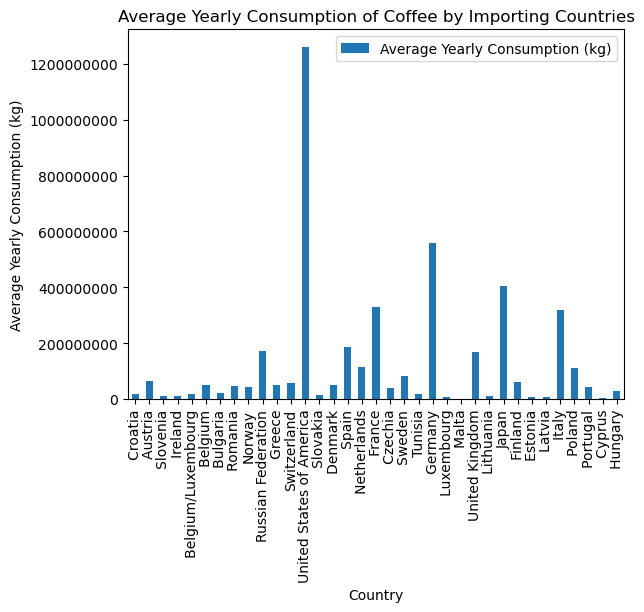

In [19]:
import_consumption = db['Coffee_ImportersConsumption'] 

#Query for finding country names
importers_data_query = import_consumption.aggregate([
    {"$group": 
     {"_id":{
        "Country": "$Country"}, 
                "count": {'$sum': 1}    
    }}
])

#Query for calculating the average consumption per year
importers_avg_query =      {
        "$group": {
            "_id":  "$Country",
            "avgConsumptionTotal": {"$avg": {"$divide": ["$Total_import_consumption", 30]}}
        }
}

pipeline = [importers_avg_query]

results = list(import_consumption.aggregate(pipeline))

importers_data = []

#Add dictionaries to list
for result in results:
    importers_data.append(result)

#Create dataframe
importers_df = pd.DataFrame(importers_data)
importers_df = importers_df.rename(columns={"_id": "Country",
                                           "avgConsumptionTotal": "Average Yearly Consumption (kg)"})
#Plot bar chart
importers_df.plot(kind="bar",
                 x="Country",
                 y="Average Yearly Consumption (kg)",
                 title="Average Yearly Consumption of Coffee by Importing Countries")
plt.xlabel("Country")
plt.ylabel("Average Yearly Consumption (kg)")

#Format the y-axis ticks in full decimal form
ax = plt.gca()
ax.yaxis.set_major_formatter('{:.0f}'.format)

plt.show()

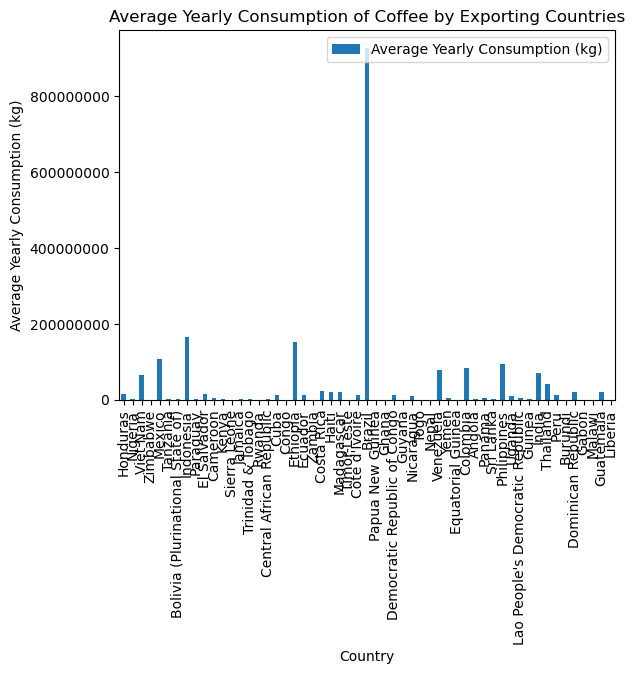

In [20]:
export_consumption = db['Coffee_DomesticConsumption'] 

#Query for finding country names
exporters_data_query = export_consumption.aggregate([
    {"$group": 
     {"_id":{
        "Country": "$Country"}, 
                "count": {'$sum': 1}    
    }}
])

#Query for calculating the average consumption per year
exporters_avg_query =      {
        "$group": {
            "_id":  "$Country",
            "avgConsumptionTotal": {"$avg": {"$divide": ["$Total_domestic_consumption", 30]}}
        }
}

pipeline = [exporters_avg_query]

results = list(export_consumption.aggregate(pipeline))

exporters_data = []

#Add dictionaries to list
for result in results:
    exporters_data.append(result)

#Create dataframe
exporters_df = pd.DataFrame(exporters_data)
exporters_df = exporters_df.rename(columns={"_id": "Country",
                                           "avgConsumptionTotal": "Average Yearly Consumption (kg)"})
#Plot bar chart
exporters_df.plot(kind="bar",
                 x="Country",
                 y="Average Yearly Consumption (kg)",
                 title="Average Yearly Consumption of Coffee by Exporting Countries")
plt.xlabel("Country")
plt.ylabel("Average Yearly Consumption (kg)")

#Format the y-axis ticks in full decimal form
ax = plt.gca()
ax.yaxis.set_major_formatter('{:.0f}'.format)

plt.show()

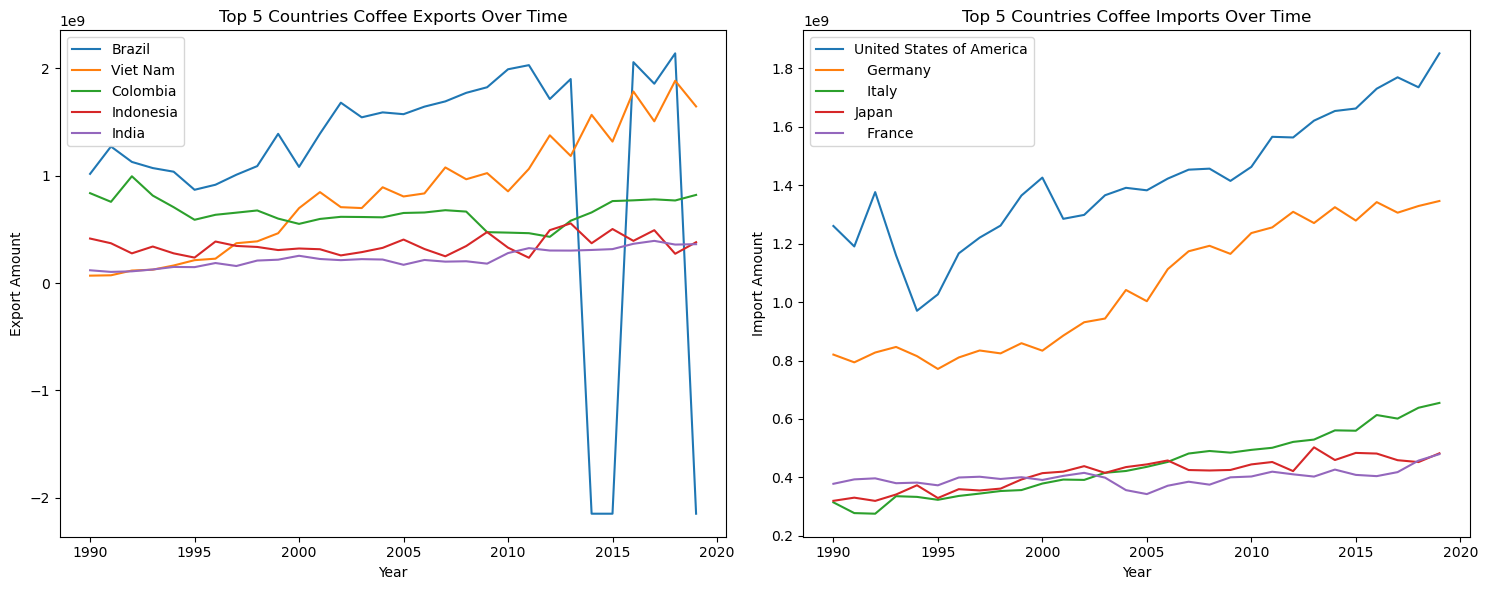

In [21]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["Global_Coffee_Consumption"]

# Select the collections for exports and imports
exports_collection = db['Coffee_exports']
imports_collection = db['Coffee_imports']

# Aggregate query to calculate the total exports and imports for each country
exports_total_pipeline = [
    {"$group": {"_id": "$Country", "total_export": {"$sum": "$Total_export"}}},
    {"$sort": {"total_export": -1}},
    {"$limit": 5}
]
exports_total = list(exports_collection.aggregate(exports_total_pipeline))

imports_total_pipeline = [
    {"$group": {"_id": "$Country", "total_import": {"$sum": "$Total_import"}}},
    {"$sort": {"total_import": -1}},
    {"$limit": 5}
]
imports_total = list(imports_collection.aggregate(imports_total_pipeline))

# Get the names of the top 5 exporting and importing countries
top_export_countries = [doc['_id'] for doc in exports_total]
top_import_countries = [doc['_id'] for doc in imports_total]

# Query the annual export and import data for these top countries
exports_query = {"Country": {"$in": top_export_countries}}
imports_query = {"Country": {"$in": top_import_countries}}

exports_data = list(exports_collection.find(exports_query))
imports_data = list(imports_collection.find(imports_query))

# Transform data to a format suitable for plotting
exports_df = pd.DataFrame(exports_data).melt(id_vars=['Country'], var_name='Year', value_name='ExportAmount')
imports_df = pd.DataFrame(imports_data).melt(id_vars=['Country'], var_name='Year', value_name='ImportAmount')

# Filter data to keep only rows with year and numeric values
exports_df = exports_df[exports_df['Year'].apply(lambda x: x.isdigit())]
imports_df = imports_df[imports_df['Year'].apply(lambda x: x.isdigit())]

# Convert year to integer
exports_df['Year'] = exports_df['Year'].astype(int)
imports_df['Year'] = imports_df['Year'].astype(int)

# Plot the line charts
plt.figure(figsize=(15, 6))

# Plot exports chart
plt.subplot(1, 2, 1)
for country in top_export_countries:
    country_data = exports_df[exports_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['ExportAmount'], label=country)
plt.title('Top 5 Countries Coffee Exports Over Time')
plt.ylabel('Export Amount')
plt.xlabel('Year')
plt.legend()

# Plot imports chart
plt.subplot(1, 2, 2)
for country in top_import_countries:
    country_data = imports_df[imports_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['ImportAmount'], label=country)
plt.title('Top 5 Countries Coffee Imports Over Time')
plt.ylabel('Import Amount')
plt.xlabel('Year')
plt.legend()

plt.tight_layout()
plt.show()



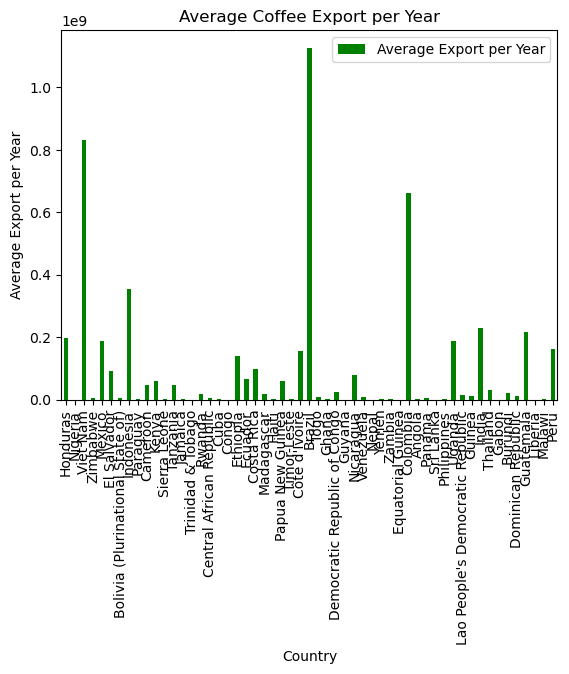

In [22]:
#Which countries export the most coffee?
#Create database
export_countries = db['Coffee_exports']

#Get country names
export_query = export_countries.aggregate([
    {"$group":
        {"_id":{
           "Country": "$Country"},
                 "count": {'$sum' : 1}
        }}
])

#Calculate average export per year, for last 30 years
avg_export_query = {
    "$group": {
        "_id": "$Country",
        "avgExport": {"$avg": {"$divide": ["$Total_export", 30]}}
    }
}

# Store results in a dictionary
pipeline = [avg_export_query]
results = list(export_countries.aggregate(pipeline))

#Create list for results, add results to list
avg_export_data = []

for result in results:
    avg_export_data.append(result)
    
# Create dataframe of results list
avg_export_df = pd.DataFrame(avg_export_data)
avg_export_df = avg_export_df.rename(columns = {"_id" : "Country",
                                                "avgExport" : "Average Export per Year"})    

# Plot bar chart
avg_export_df.plot(kind = "bar",
                  x = "Country",
                  y = "Average Export per Year",
                  title = "Average Coffee Export per Year",
                  color = "green")
plt.xlabel("Country")
plt.ylabel("Average Export per Year")
plt.show()

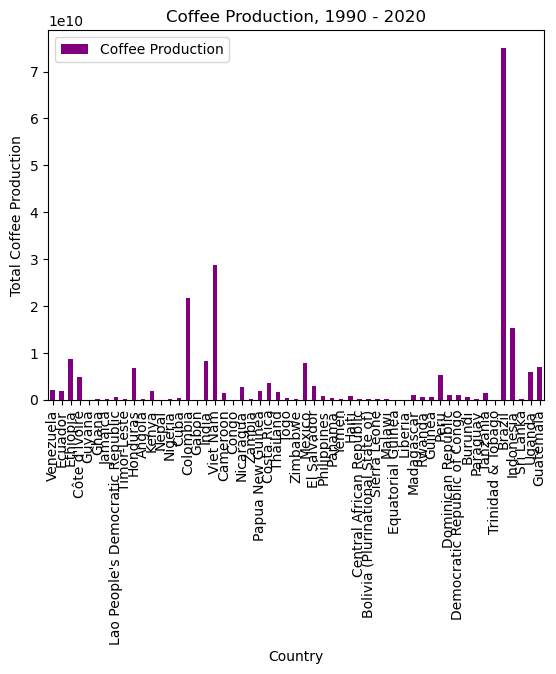

In [23]:
#Coffee production bar graph
#Create database
production_countries = db['Coffee_production']

#Get country names
production_query = production_countries.aggregate([
    {"$group":
        {"_id":{
            "Country": "$Country"},
                 "count": {'$sum' : 1}
        }}
])

#Calculate total production
total_export_query = {
    "$group": {
        "_id": "$Country",
        "totalproduction": {"$sum": {"$sum" : ["$Total_production"]}}
    }
}

#Store results in a dictionary
pipeline = [total_export_query]
results = list(production_countries.aggregate(pipeline))

#Create list for results, add results to list
total_production_data = []

for result in results:
    total_production_data.append(result)
    
    
#Create dataframe of results list
total_production_df = pd.DataFrame(total_production_data)
total_production_df = total_production_df.rename(columns = {"_id" : "Country",
                                                           "totalproduction" : "Coffee Production"})

total_production_df.plot(kind = "bar",
                  x = "Country",
                  y = "Coffee Production",
                  title = "Coffee Production, 1990 - 2020",
                  color = "purple")
plt.xlabel("Country")
plt.ylabel("Total Coffee Production")
plt.show()

In [24]:
#Global map of coffee production
#Import dependencies
import requests
import json
import hvplot.pandas
import pandas as pd
geoapify_key = "f89649cb87324778b6a5d5fe7f466a73"

#Create database
production_map_df = pd.DataFrame(total_production_df["Country"])
production_map_df["30 Year Production"] = total_production_df["Coffee Production"]

lats = []
lons = []

for country in total_production_df["Country"]:
    target_country = country
    target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_country}&format=json&apiKey={geoapify_key}"
    geo_data = requests.get(target_url).json()
    lats.append(geo_data["results"][0]["lat"])
    lons.append(geo_data["results"][0]["lon"])
    
lats_df = pd.DataFrame(lats)
lons_df = pd.DataFrame(lons)

production_map_df["Latitude"] = lats_df[0]
production_map_df["Longitude"] = lons_df[0]

production_map_plot = production_map_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    size = "30 Year Production",
    scale = 0.0002,
    color = "Country")

production_map_plot

ImportError: Geographic projection support requires: cartopy, geoviews, pyproj.